In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from biom import load_table
from skbio.stats.composition import ancom, closure
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
%matplotlib inline

In [23]:
% matplotlib inline

# Formats the axes using seabron so they will be white, and have ticks
# on the bottom of the axes.
# sns.set_style('ticks', {'axes.facecolor': 'none', 'xtick.direction': 'in', 'ytick.direction': 'in'})

from matplotlib import rcParams
# Sets up plotting parameters so that the default setting is use to Helvetica
# in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True

These tables were obtained through 10k rarified OTU tables on fecal samples.  
The otu table was then normalized by copy number and metagenomic abundances were predicted from the normalized OTU table

In [24]:
table = load_table('../data/ag_10k_fecal_pathway3.biom')
metadata = pd.read_table('../data/ag_fecal.txt', index_col=0)
singles = pd.read_table('../data/single_ids_10k.txt', index_col=0)

We'll also convert all of the abundances to proportions.  Zeros will be handled by adding 1 to everything.

In [25]:
mat = np.array(table.matrix_data.todense()).T
df = pd.DataFrame(closure(mat+1), 
                  index=table.ids(axis='sample'), 
                  columns=table.ids(axis='observation'))

We'll only isolate the single samples, to avoid any dependence issues when running statistical tests.

Since the `TYPES_OF_PLANTS` was dropped in later studies, we'll only look at the participants that answered this question.

In [26]:
metadata = metadata.loc[singles.index, :]
metadata = metadata.loc[metadata['TYPES_OF_PLANTS'] != 'Unknown', :]
metadata = metadata.loc[pd.notnull(metadata['TYPES_OF_PLANTS']), :]

In [27]:
df = df.loc[list(set(df.index) & set(metadata.index)), :]
metadata = metadata.loc[list(set(df.index) & set(metadata.index)), :]

In [28]:
res = ancom(df, metadata['TYPES_OF_PLANTS'])

We'll extract only the significant OTUs detected by ANCOM.  Then we'll log transform the data and subtract out the means.  It'll make it easier to visualize on the heatmaps.

In [29]:
sig = res[res['reject']==True]
df = np.log(df)
df = df - df.mean(axis=0)
df = pd.merge(df, pd.DataFrame(metadata['TYPES_OF_PLANTS']), left_index=True, right_index=True)

In [30]:
grps = df.groupby('TYPES_OF_PLANTS')
subgrps = (grps.mean() / grps.std())[sig.index]

In [31]:
labs = ['Less than 5', '6 to 10', '11 to 20', '21 to 30', 'More than 30']
subgrps = subgrps.reindex_axis(labs)
subgrps = subgrps.T

In [32]:
subgrps.sort_values('Less than 5', inplace=True)

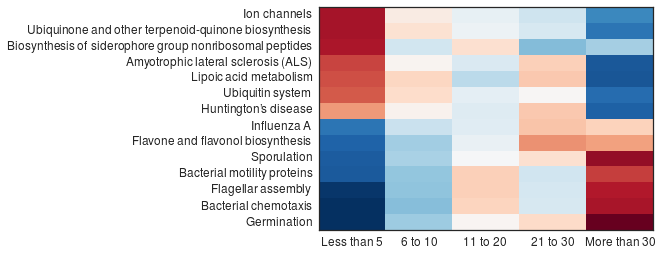

In [34]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(subgrps, cmap=plt.cm.RdBu_r)

# put the major ticks at the middle of each cell
_ = ax.set_xticks(np.arange(subgrps.shape[1])+0.5, minor=False)
_ = ax.set_yticks(np.arange(subgrps.shape[0])+0.5, minor=False)

_ = ax.set_xticklabels(subgrps.columns, minor=False, size=12)
_ = ax.set_yticklabels(subgrps.index, minor=False, size=12)

fig.savefig('/Users/jdebelius/Desktop/plants_heatmap.pdf')

Another way to visualize this is through boxplots.  This will give us a better idea about the variance between groups.

In [13]:
df = pd.DataFrame(np.log(closure(mat+1)), 
                  index=table.ids(axis='sample'), 
                  columns=table.ids(axis='observation'))
df = df.loc[:, sig.index]
df = pd.merge(df, pd.DataFrame(metadata['TYPES_OF_PLANTS']), left_index=True, right_index=True)
mdf = pd.melt(df, id_vars='TYPES_OF_PLANTS', var_name='Pathway', value_name='Abundance')

If the colors need to be changed, a dictionary can be passed into the palette parameter in the `boxplot` function.

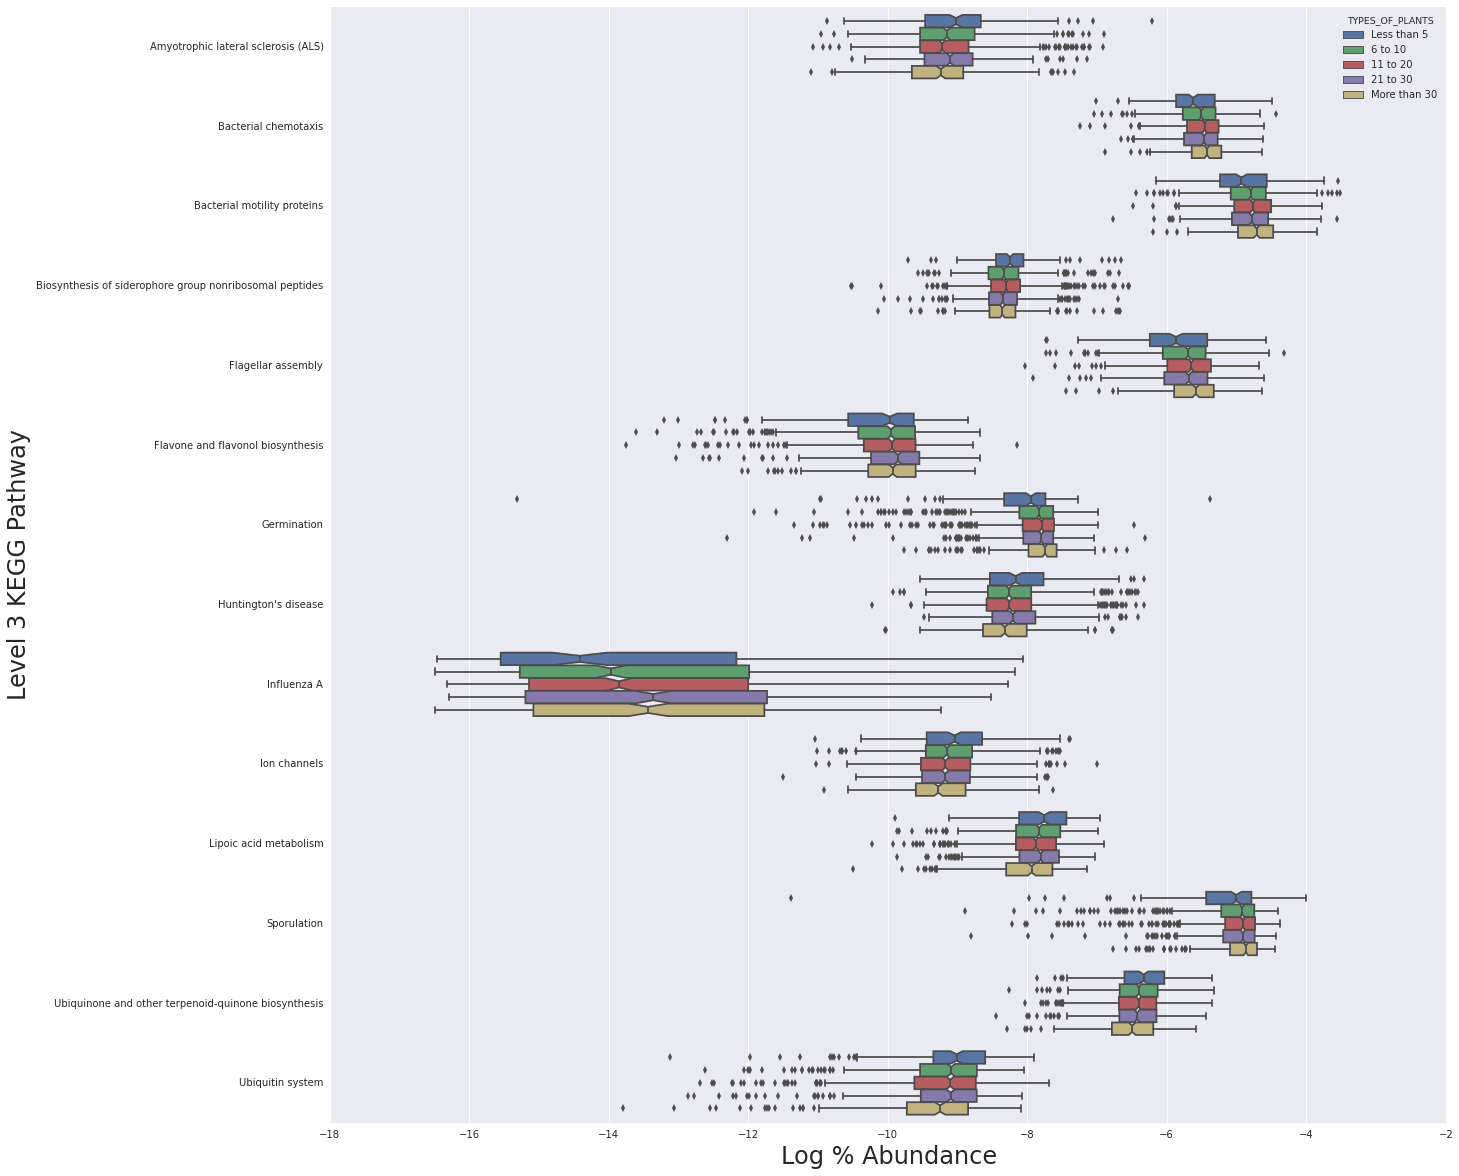

In [16]:
font = {'family' : 'normal',
        'size'   : 28}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(20, 20))
_ = sns.boxplot(hue='TYPES_OF_PLANTS', x='Abundance', y='Pathway', data=mdf, 
                hue_order=labs,
                orient='h', ax=ax, notch=True)
ax.set_xlabel('Log % Abundance', fontsize=24)
ax.set_ylabel('Level 3 KEGG Pathway', fontsize=24)